In [2]:
import math
import pandas as pd
import os
from os import path
from tqdm import tqdm
import json
import cv2
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import datetime
import time
import random
from PIL import Image
import pickle
import joblib
import re

from sklearn import preprocessing
import tensorflow as tf
from keras.layers import Input,Dense,LSTM,Flatten,Dropout,concatenate,Conv1D,MaxPooling2D,Activation
from keras.layers import BatchNormalization
from keras.layers import Embedding
from tensorflow.keras import initializers, regularizers
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
# import keras_tuner
from tensorflow import keras
import tensorflow_hub as hub
#import imgaug.augmenters as iaa
from tensorflow.keras.preprocessing import image, text, sequence
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.callbacks import ModelCheckpoint
import numpy as np

import warnings
warnings.filterwarnings("ignore")

In [3]:
data_df_k1000 = pd.read_csv("/kaggle/input/my-data/mscoco_train2014_k1000_50k.csv")
data_df_k1000.head(10)

,image_id,question,answer,answers,que_firstword
0,train2014/COCO_train2014_000000159768.jpg,What design is on the curtains?,stripes,"tan,stripes,stripes,stripes,stripes,stripes,st...",what
1,train2014/COCO_train2014_000000157176.jpg,Is it early morning?,no,"no,no,no,no,no,no,no,yes,no,no",is
2,train2014/COCO_train2014_000000224168.jpg,What is the cat in?,bowl,"bowl,bowl,bowl,bowl,bowl,bowl,bowl,bowl,bowl,bowl",what
3,train2014/COCO_train2014_000000322638.jpg,Is this bathroom finished?,yes,"yes,yes,yes,yes,yes,yes,yes,yes,yes,yes",is
4,train2014/COCO_train2014_000000577759.jpg,What tool is using to cut?,scissors,"scissors,scissors,scissors,scissors,scissors,s...",what
5,train2014/COCO_train2014_000000119743.jpg,What color is the helmet?,orange,"orange,orange,orange,orange,orange,orange,oran...",what
6,train2014/COCO_train2014_000000351033.jpg,Are both surfer's on their surfboards?,yes,"yes,yes,yes,no,yes,no,yes,yes,yes,yes",are
7,train2014/COCO_train2014_000000236772.jpg,Is this a normal toilet seat like everyone else?,yes,"yes,yes,yes,yes,yes,yes,yes,yes,yes,no",is
8,train2014/COCO_train2014_000000211302.jpg,Are those chairs retro?,yes,"yes,yes,yes,yes,yes,no,yes,yes,yes,yes",are
9,train2014/COCO_train2014_000000218368.jpg,What brand is the man's phone?,apple,"iphone,apple,apple,iphone,apple,apple,apple,ip...",what


(500, 375, 3)
Are the flowers in full bloom?


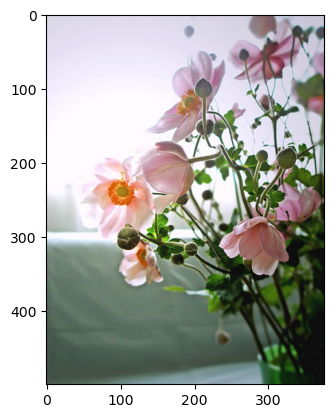

In [21]:
Image_dataset_path ='/kaggle/input/ms-coco/train2014/'
print_index = 100
image = Image_dataset_path + data_df_k1000.image_id[print_index]
image_vect = cv2.imread(image)
image_vect = cv2.cvtColor(image_vect, cv2.COLOR_BGR2RGB)

print(image_vect.shape)
print(data_df_k1000.question[print_index])
plt.imshow(image_vect)

In [17]:
le = preprocessing.LabelEncoder()
le.fit(list(data_df_k1000['answer']))
data_df_k1000['class_label'] = le.transform(list(data_df_k1000['answer']))
print("Number of classes:"+ str(len(le.classes_)))
data_df_k1000.head(3)

Number of classes:1000


,image_id,question,answer,answers,que_firstword,class_label
0,train2014/COCO_train2014_000000159768.jpg,What design is on the curtains?,stripes,"tan,stripes,stripes,stripes,stripes,stripes,st...",what,850
1,train2014/COCO_train2014_000000157176.jpg,Is it early morning?,no,"no,no,no,no,no,no,no,yes,no,no",is,583
2,train2014/COCO_train2014_000000224168.jpg,What is the cat in?,bowl,"bowl,bowl,bowl,bowl,bowl,bowl,bowl,bowl,bowl,bowl",what,146


In [19]:
# to get 50k datapoints from dataset with same %count as in dataset

X = data_df_k1000[['image_id','question','answer','class_label']]
y = data_df_k1000['class_label']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.10, stratify=y, random_state=42) 
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.10, stratify=y_train, random_state=42) 
print('X_train.shape:',X_train.shape)
print('y_train.shape:',y_train.shape)
print('X_val.shape:',X_val.shape)
print('y_val.shape:',y_val.shape)

X_train.shape: (40502, 4)
y_train.shape: (40502,)
X_val.shape: (5001, 4)
y_val.shape: (5001,)


In [22]:
vocab_size = 10000
embedding_dim = 256
max_length = 50
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"

# column to list using Series.tolist()
question_list_train = X_train["question"].tolist()
#tokenizer part
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(question_list_train)

In [29]:
class DataGenerator(tf.keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self,tokenizer,
                 #encoder,
                 Question_batch,Image_batch,Answer_label_batch,path, batch_size, dim=(224,224),
                 n_classes=1000,shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        #self.labels = labels
        #self.list_IDs = list_IDs
        #self.n_channels = n_channels
        self.indexes = np.arange(len(Answer_label_batch))
        self.n_classes = n_classes
        self.shuffle = shuffle

        self.tokenizer = tokenizer
        #self.encoder = encoder
        self.Image_batch = Image_batch
        self.Question_batch = Question_batch
        self.Answer_label_batch = Answer_label_batch
        self.path = path
        
        #self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return len(self.indexes) // self.batch_size

    def __getitem__(self, index):
        
        Qstn = self.Question_batch[index * self.batch_size:(index + 1) * self.batch_size]
        IMG = self.Image_batch[index * self.batch_size:(index + 1) * self.batch_size]
        Ans = self.Answer_label_batch[index * self.batch_size:(index + 1) * self.batch_size]

        
        qstn = np.asarray([self.__get_question_(que) for que in Qstn])
        img = np.asarray([self.__get_Image_(self.path + i ) for i in IMG])
        ans = np.asarray([self.__get_output_(c) for c in Ans])
       
        return tuple([img, qstn]), ans

    def __get_question_(self, que):
    
        #que_arr = (pad_sequences(t.texts_to_sequences([X_que]), maxlen=22, padding='post'))[0]
        sequences = self.tokenizer.texts_to_sequences([que])
        sequence_padded = (pad_sequences(sequences, maxlen=50, padding='post'))[0]
        
        return sequence_padded

    def __get_Image_(self, path):

        img = cv2.imread(path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        #resize image as (224,224,3)
        resized_img = cv2.resize(img,self.dim)
        #normalize inage
        img = np.array(resized_img)/255.0
            
        return img

    def __get_output_(self, answer):
        return tf.keras.utils.to_categorical(answer, num_classes=self.n_classes)
        #return self.encoder.fit_transform(train_data[['answer']]).toarray()

    def on_epoch_end(self):
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)

batch = 16
traingen = DataGenerator(tokenizer,
                         #encoder,
                         list(X_train['question']),
                         list(X_train['image_id']),
                         list(y_train),
                         Image_dataset_path,
                         batch_size=batch,
                         )
valgen = DataGenerator(tokenizer,
                       #encoder,
                       list(X_val['question']),
                       list(X_val['image_id']),
                       list(y_val),
                       Image_dataset_path,
                       batch_size=batch,
                       )

In [26]:
pre_trained_model = tf.keras.applications.VGG19(input_shape=(224, 224, 3), include_top=True, weights="imagenet", pooling='avg')
for layer in pre_trained_model.layers:
    layer.trainable = False

regularizer = tf.keras.regularizers.l2(0.01)

for layer in pre_trained_model.layers:
    for attr in ['kernel_regularizer']:
        if hasattr(layer, attr):
          setattr(layer, attr, regularizer)

vgg19_fc2_output = (pre_trained_model.get_layer('fc2')).output
img = Dense(units=1024,activation='relu',kernel_initializer='he_normal')(vgg19_fc2_output)
img = Dropout(0.2)(img)

input_layer_que = Input(shape=(50,))
#embedding = Embedding(1014, 300, weights=[embedding_matrix_vocab], input_length=100, trainable=False)(input_layer_que)
embedding = Embedding(input_dim=10000,output_dim=256,input_length=max_length)(input_layer_que)
lstm1 = LSTM(64, return_sequences=True)(embedding)
dropout1 = Dropout(0.5)(lstm1)
lstm2 = LSTM(64)(dropout1)
dropout2 = Dropout(0.5)(lstm2)
que = Dense(units=1024,activation='relu',kernel_initializer='he_normal')(dropout2)

pointwise_mul = tf.math.multiply(que, img)

output = Dense(units=1000,activation='softmax',kernel_initializer="glorot_uniform")(pointwise_mul)

model_lstm_vgg19 = Model(inputs=[pre_trained_model.input,input_layer_que],outputs=output)

# compile
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model_lstm_vgg19.compile(optimizer=optimizer,loss='categorical_crossentropy',metrics=['accuracy'])

model_lstm_vgg19.summary()

574710816/574710816 [==============================] - 3s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 224, 224, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 224, 224, 64  36928       ['block1_conv1[0][0]']           
                           

In [36]:
#run_opts = tf.RunOptions(report_tensor_allocations_upon_oom = True)
# compile
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model_lstm_vgg19.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'],
                         #options=run_opts
                         )
# vqa_model.fit([Training_pair[0],Training_pair[1]],
#               train_answer_encoded,
#               validation_data=([Validation_pair[0],Validation_pair[1]],val_answer_encoded),
#               epochs=5,
#               batch_size=128)

checkpoint_filepath="/kaggle/working/weights-{epoch:02d}-{val_accuracy:.4f}.hdf5"
model_checkpoint_callback = ModelCheckpoint(filepath=
                                            checkpoint_filepath,
                                            monitor='val_accuracy',
                                            verbose=0,
                                            save_best_only=True,
                                            mode='max')
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                 factor=0.2,
                                                 patience=2,
                                                 min_lr=0.001)
early_stop = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                
                                                patience=2,
                                                verbose=1,
                                                mode="auto",
                                                baseline=None,
                                                restore_best_weights=False,
                                                start_from_epoch=0,
)

In [37]:
history = model_lstm_vgg19.fit(traingen,
                        batch_size=16,
                        epochs=30,
                        verbose=1,
                        validation_data=valgen,
                        callbacks=[model_checkpoint_callback,
                                   reduce_lr,
                                  early_stop]
                       )

Epoch 1/30
2531/2531 [==============================] - 544s 212ms/step - loss: 2.6863 - accuracy: 0.2994 - val_loss: 2.7002 - val_accuracy: 0.3047 - lr: 1.0000e-04
Epoch 2/30
2531/2531 [==============================] - 549s 217ms/step - loss: 2.6421 - accuracy: 0.3042 - val_loss: 2.6749 - val_accuracy: 0.2965 - lr: 1.0000e-04
Epoch 3/30
2531/2531 [==============================] - 531s 210ms/step - loss: 2.6144 - accuracy: 0.3018 - val_loss: 2.6637 - val_accuracy: 0.3101 - lr: 1.0000e-04
Epoch 4/30
2531/2531 [==============================] - 525s 207ms/step - loss: 2.5843 - accuracy: 0.3053 - val_loss: 2.6533 - val_accuracy: 0.3069 - lr: 1.0000e-04
Epoch 5/30
2531/2531 [==============================] - 537s 212ms/step - loss: 2.5644 - accuracy: 0.3071 - val_loss: 2.6515 - val_accuracy: 0.3115 - lr: 1.0000e-04
Epoch 6/30
2531/2531 [==============================] - 530s 209ms/step - loss: 2.5408 - accuracy: 0.3088 - val_loss: 2.6376 - val_accuracy: 0.3135 - lr: 1.0000e-04
Epoch 7/30

In [ ]:
base_model = keras.applications.Xception(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(150, 150, 3),
    include_top=False)  # Do not include the ImageNet classifier at the top.

In [ ]:
test_image_path = list(X_test['image_id'])
test_question = list(X_test['question'])
test_answer = list(y_test)

# Plot test images, questions, actual answers and predicted answers
fig = plt.figure(figsize=(24, 10))
for a,i in enumerate(list(np.arange(10))):
  fig.add_subplot(2, 5, a+1)
  img = cv2.imread(Image_dataset_path+test_image_path[i]+'.png')
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  plt.imshow(img); plt.axis('off')
  plt.title(f'Que: {test_question[i]} \nActual Ans: {le.inverse_transform(test_answer)[i]} \nPredicted Ans:
  {le.inverse_transform([np.argmax(model_lstm_vgg19.predict([np.array([test_que[i]]),np.array([test_image[i]])],verbose=0))])[0]}')